# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest
from pmdarima.arima import ndiffs


import warnings
warnings.filterwarnings('ignore')

## 5.44 Data from the Western Regional Climate Center 
for the monthly mean daily solar radiation (in Langleys) at the Zion Canyon, Utah, station are shown in Table B.24. This data has a strong seasonal component. Use the data from 2003 to 2012 to develop an appropriate ARIMA model for this data. Use this model to simulate one-monthahead forecasts for the remaining years. Calculate the forecast errors. Discuss the reasonableness of the forecasts.

In [3]:
# Define the data for solar radiation
data = {
    'Year': [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
    'Jan': [np.nan, 212, 166, 184, 220, 176, 214, 213, 242, 246, 232, 205],
    'Feb': [np.nan, 229, 216, 272, 263, 270, 240, 282, 294, 321, 333, 265],
    'Mar': [np.nan, 453, 385, 310, 396, 415, 423, 440, 389, 425, 457, 401],
    'Apr': [np.nan, 503, 508, 477, 466, 569, 487, 546, 533, 560, 506, 479],
    'May': [np.nan, 619, 529, 572, 590, 542, 593, 672, 584, 713, 541, 549],
    'Jun': [np.nan, 615, 549, 583, 634, 647, 586, 703, 703, 733, 645, 642],
    'Jul': [np.nan, 573, 579, 508, 542, 569, 638, 665, 597, 550, 494, np.nan],
    'Aug': [np.nan, 535, 474, 509, 511, 499, 617, 595, 625, 517, 463, np.nan],
    'Sep': [np.nan, 464, 443, 431, 432, 459, 523, 570, 488, 485, 412, np.nan],
    'Oct': [np.nan, 262, 302, 291, 316, 333, 367, 322, 371, 367, 320, np.nan],
    'Nov': [184, 208, 224, 211, 233, 208, 283, 244, 248, 241, 207, np.nan],
    'Dec': [178, 175, 170, 177, 179, 157, 196, 153, 214, 158, 180, np.nan]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt into long format
df_long = df.melt(id_vars='Year', var_name='Month', value_name='Sol')

# Combine Year and Month into datetime
df_long['Date'] = pd.to_datetime(df_long['Month'] + '-' + df_long['Year'].astype(str), format='%b-%Y')

# Set index and sort
df_long = df_long.set_index('Date').sort_index()

# Drop extra columns
df_final = df_long[['Sol']]

# Display
df_final.head(12)

,Sol
Date,
2003-01-01,NaN
2003-02-01,NaN
2003-03-01,NaN
2003-04-01,NaN
2003-05-01,NaN
2003-06-01,NaN
2003-07-01,NaN
2003-08-01,NaN
2003-09-01,NaN


In [4]:
# Drop the first 10 values and last 6 values from the dataframe
df_solar_radiation = df_final.iloc[10:-6]

# Display the result
df_solar_radiation

,Sol
Date,
2003-11-01,184.0
2003-12-01,178.0
2004-01-01,212.0
2004-02-01,229.0
2004-03-01,453.0
...,...
2014-02-01,265.0
2014-03-01,401.0
2014-04-01,479.0


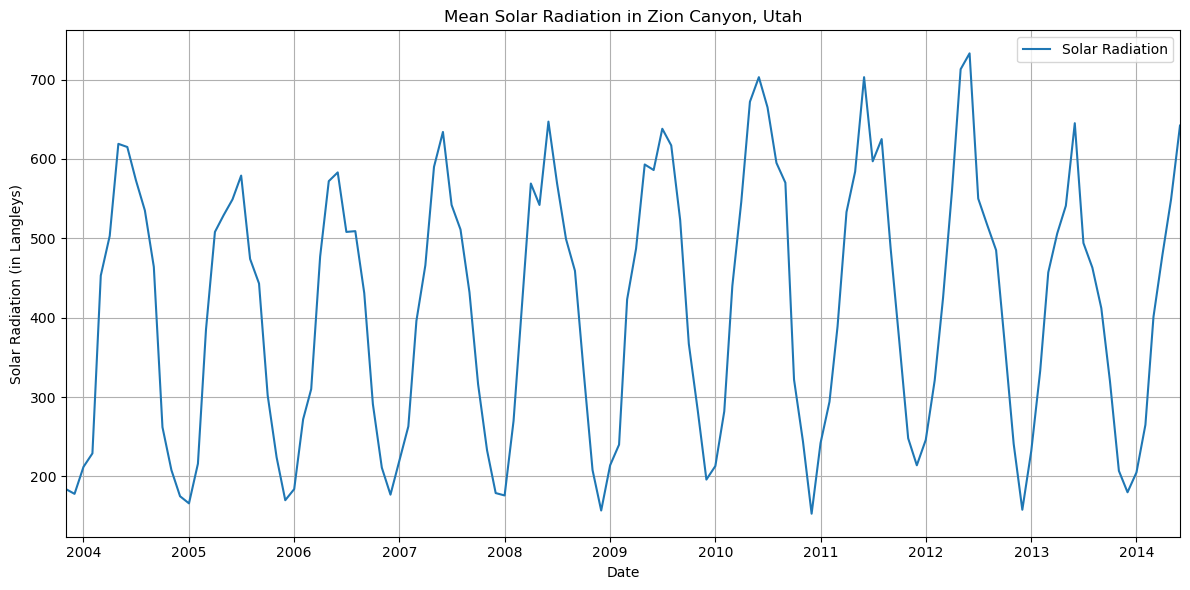

In [5]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_solar_radiation.index, df_solar_radiation['Sol'], label='Solar Radiation')     

plt.title('Mean Solar Radiation in Zion Canyon, Utah')                      
plt.xlabel('Date')                                        
plt.ylabel('Solar Radiation (in Langleys)')  
plt.xlim(pd.to_datetime('2003-11-01'), pd.to_datetime('2014-06-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [6]:
# Split the data
train = df_solar_radiation[df_solar_radiation.index.year < 2012]     # All data before 2012
test = df_solar_radiation[df_solar_radiation.index.year >= 2012]     # All data in 2012

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (98, 1)
Test shape: (30, 1)




(              Sol
 Date             
 2011-08-01  625.0
 2011-09-01  488.0
 2011-10-01  371.0
 2011-11-01  248.0
 2011-12-01  214.0,
 None,
               Sol
 Date             
 2012-01-01  246.0
 2012-02-01  321.0
 2012-03-01  425.0
 2012-04-01  560.0
 2012-05-01  713.0)

In [7]:
sol_series = train['Sol']

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(sol_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.47364306736796524
p-value: 0.8970580633573565

p-value > alpha; H0: Not Stationary


In [9]:
# First-Order differencing
eps_diff = np.diff(sol_series, n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.9253032215819923
p-value: 0.0018563228975469477

p-value < alpha; Ha: Stationary


    d = 1

In [10]:
from statsmodels.tsa.stattools import adfuller

def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(sol_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -0.4736, p-value = 0.8971
d = 1 | ADF Statistic = -3.9253, p-value = 0.0019

Non-seasonal differencing term (d): 1


In [11]:
from pmdarima.arima import nsdiffs


def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

D = determine_seasonal_D(sol_series, 12)
print(f'Seasonal differencing term (D): {D}')

Seasonal differencing term (D): 0


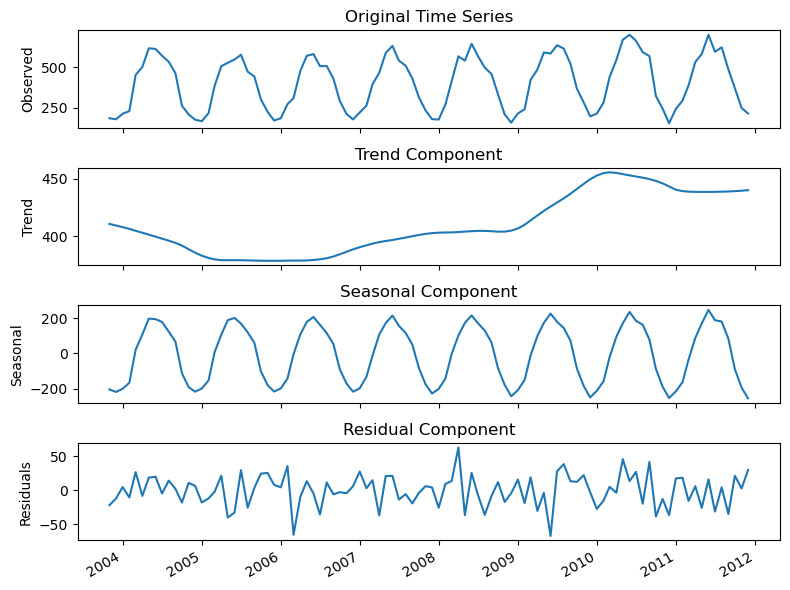

In [12]:
decom_air = STL(sol_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [13]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    sol_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(3, 1, 2)(0, 0, 0, 12)


In [14]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2            # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(sol_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,63,"(0, 1, 3)","(3, 0, 3)",585.087439,589.870048,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,127,"(1, 1, 3)","(3, 0, 3)",586.846197,592.712864,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,123,"(1, 1, 3)","(2, 0, 3)",588.738794,593.521402,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,59,"(0, 1, 3)","(2, 0, 3)",590.189454,594.019241,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,205,"(3, 1, 0)","(3, 0, 1)",591.957368,594.896143,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


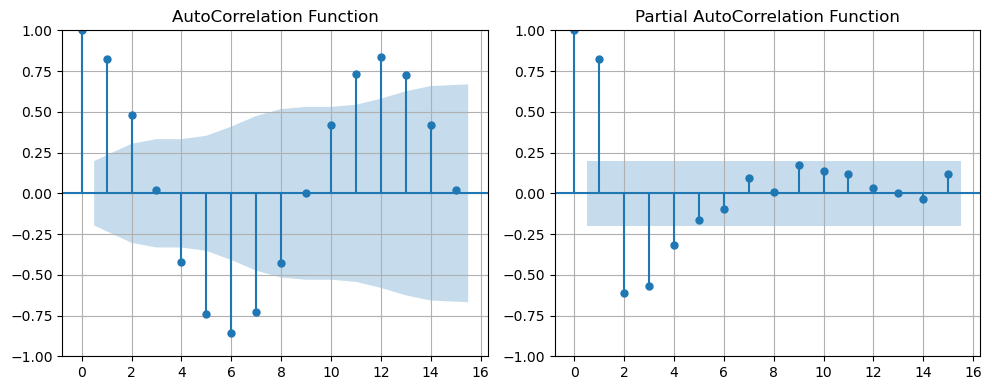

In [15]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(sol_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(sol_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_013 = SARIMAX(sol_series,                          # Time series data
                    order=(0, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(3, 0, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_013 = model_013.fit()

# Display summary of the model
print(model_fit_013.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                Sol   No. Observations:                   98
Model:             SARIMAX(0, 1, 3)x(3, 0, 3, 12)   Log Likelihood                -282.544
Date:                            Tue, 08 Apr 2025   AIC                            585.087
Time:                                    14:30:05   BIC                            605.518
Sample:                                11-01-2003   HQIC                           593.027
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7712     16.051     -0.048      0.962     -32.231      30.688
ma.L2          0.0489      3.672   

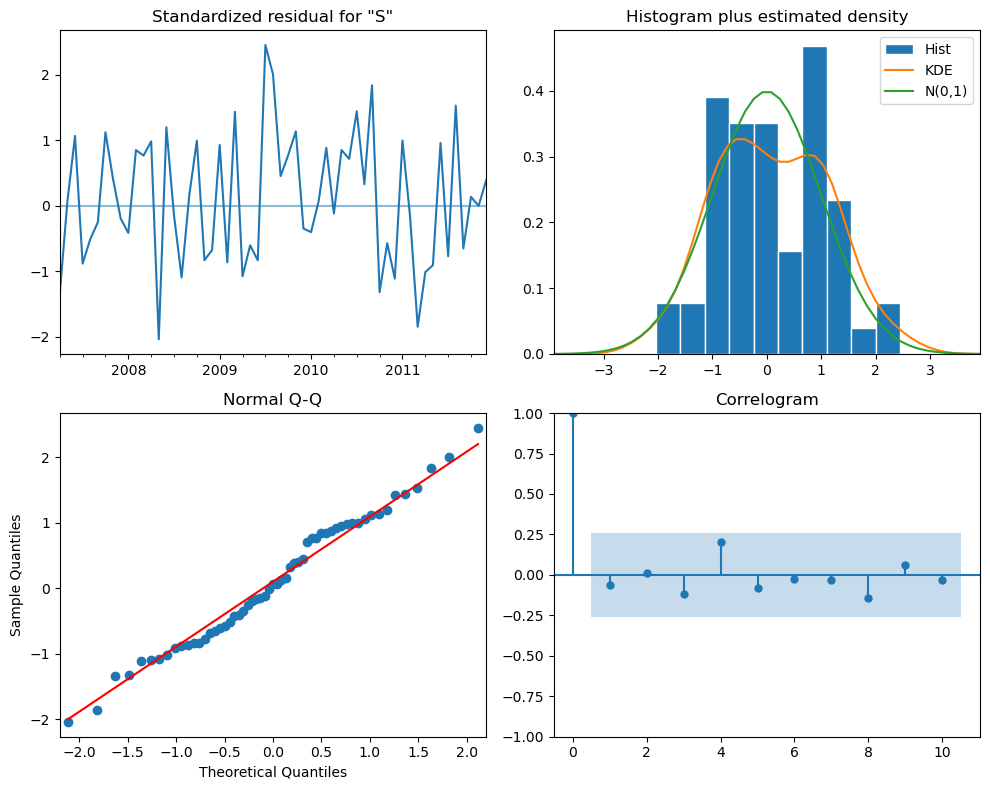

In [17]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_013.resid  

# Diagnostic plots for the model, including residuals and other model checks
model_fit_013.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [18]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,3.066674,0.079913
2,7.177628,0.027631
3,7.288563,0.063247
4,8.906415,0.063482
5,15.329140,0.009045
6,20.171663,0.002581
7,25.313600,0.000668
8,31.882828,0.000098
9,32.384533,0.000171
10,32.930423,0.000280


In [19]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_312 = SARIMAX(sol_series,                          # Time series data
                    order=(3, 1, 2),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_312 = model_312.fit()

# Display summary of the model
print(model_fit_312.summary())

                               SARIMAX Results                                
Dep. Variable:                    Sol   No. Observations:                   98
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -482.477
Date:                Tue, 08 Apr 2025   AIC                            976.955
Time:                        14:30:05   BIC                            992.215
Sample:                    11-01-2003   HQIC                           983.119
                         - 12-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2043      0.084     14.256      0.000       1.039       1.370
ar.L2         -0.0843      0.148     -0.570      0.568      -0.374       0.205
ar.L3         -0.5233      0.085     -6.136      0.0

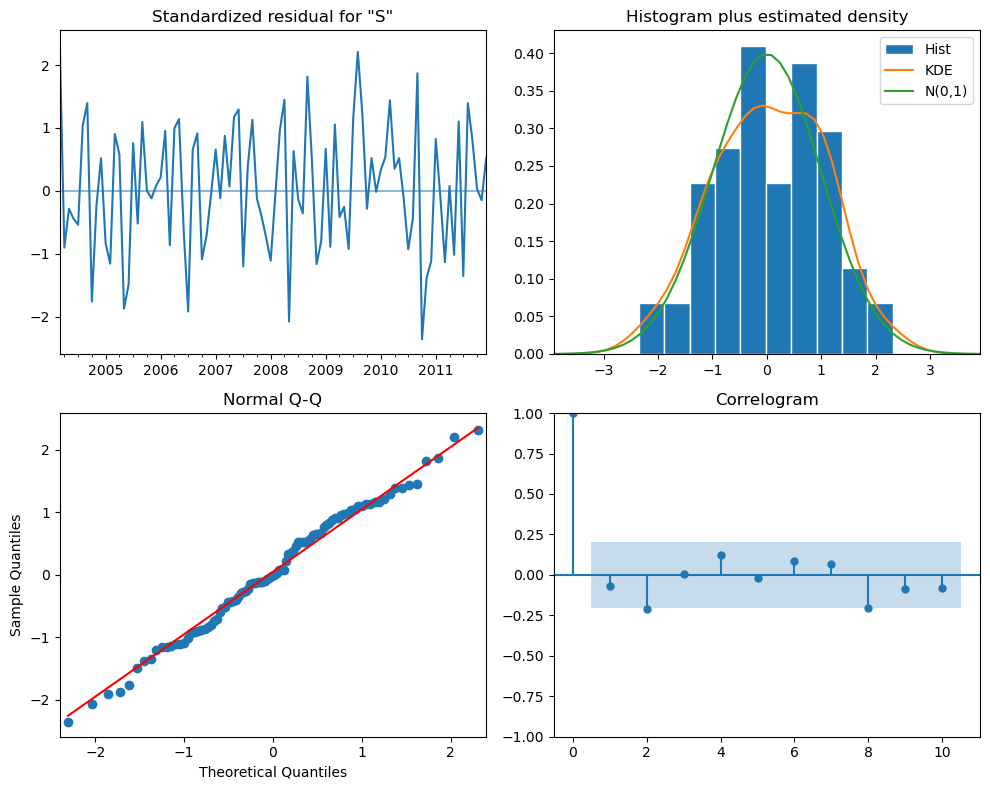

In [20]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_312.resid  

# Diagnostic plots for the model, including residuals and other model checks
model_fit_312.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [21]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,3.770493,0.052164
2,4.383573,0.111717
3,5.808456,0.121310
4,12.036428,0.017082
5,12.192103,0.032248
6,12.975569,0.043426
7,13.009678,0.071873
8,16.068576,0.041409
9,16.405096,0.058889
10,16.449119,0.087477


In [22]:
# Forecast the next 12 time points
forecast_30m = model_fit_312.get_forecast(steps=30)

# Extract predicted mean and confidence intervals
forecast_mean_30 = forecast_30m.predicted_mean
conf_int_30 = forecast_30m.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_30.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Sol']

test['Lower 95% CI'] = conf_int_30.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_30.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Sol,Forecast,Error,Lower 95% CI,Upper 95% CI
Date,,,,,
2012-01-01,246.0,201.557715,-44.442285,123.618919,279.496511
2012-02-01,321.0,273.003041,-47.996959,188.994289,357.011793
2012-03-01,425.0,377.882092,-47.117908,284.802730,470.961454
2012-04-01,560.0,504.673519,-55.326481,410.587403,598.759634
2012-05-01,713.0,611.138874,-101.861126,516.884440,705.393308
2012-06-01,733.0,673.784398,-59.215602,579.310331,768.258465
2012-07-01,550.0,673.906101,123.906101,579.206843,768.605359
2012-08-01,517.0,613.061950,96.061950,518.352826,707.771074
2012-09-01,485.0,506.998276,21.998276,411.635780,602.360772


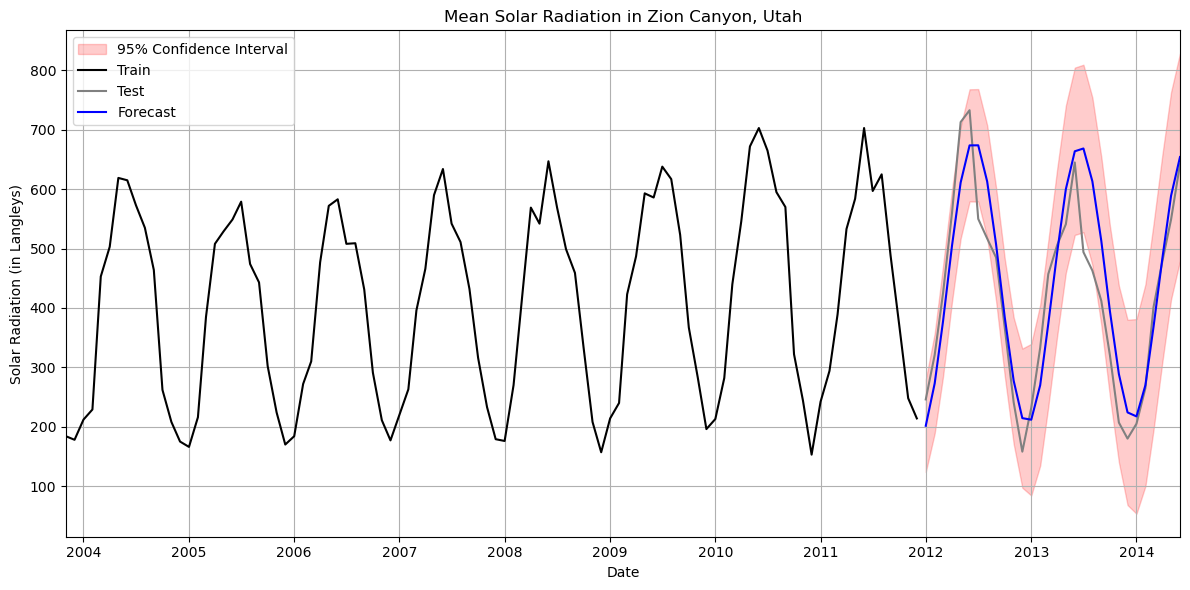

In [23]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_30.iloc[:, 0],     # Lower bound
                 conf_int_30.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Sol'], label='Train', color='black')         # Train
plt.plot(test.index, test['Sol'], label='Test', color='gray')             # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Mean Solar Radiation in Zion Canyon, Utah')                      
plt.xlabel('Date')                                        
plt.ylabel('Solar Radiation (in Langleys)')  
plt.xlim(pd.to_datetime('2003-11-01'), pd.to_datetime('2014-06-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [24]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Sol']).mean() * 100

# Print the result
print(f"MAPE SARIMA(0,1,3)(3,0,3)[12] model: {mape:.2f}%")

MAPE SARIMA(0,1,3)(3,0,3)[12] model: 14.86%


This means that the `SARIMA(0,1,3)(3,0,3)[12]` model has an average prediction error of 14.86% when applied to our test data. In other words, on average, the model's predictions are off by about 14.86% from the actual values (the `Production`).